# Problem description

This notebook illustrates a CPLEX MIP model and a CP Optimizer mode to solve a single-machine scheduling problem.

# Reading the data

In [1]:
Duration = [2,4,1,1,1,2]
Precedences = [[0,2], [0,3], [2,4], [3,4], [3,5]]

#Duration = [2,4,1,1,1,2,2,4,5,6,2,4,1,8,4,6,3,1,5,6,3,8]
#Precedences = [[0,2], [0,3], [2,4], [3,4], [3,5], [3,11], [4,17],[11,18],[7,9],[16,18]]

n = len(Duration)

# Modeling the problem with CPLEX Optimizer

In [2]:
# Import MIP modelization functions
from docplex.mp.model import *

# Create model object
model = Model()

M = sum(Duration[i] for i in range(n))

# Decision variables
before = [ [ model.binary_var() for i in range(n)] for j in range(n) ]
start  = [ model.integer_var() for i in range(n)]

# Constraints
model.add_constraints((before[i][i] == 0) for i in range(n))
model.add_constraints((before[i][j] == 1-before[j][i]) for i in range(n) for j in range(n) if i<j)
model.add_constraints((start[i]+Duration[i] <= start[j] + M*before[j][i]) for i in range(n) for j in range(n) if i!=j)

model.add_constraints((start[p[0]]+Duration[p[0]] <= start[p[1]]) for p in Precedences)
cost = model.sum(start[i]+Duration[i] for i in range(n))
model.minimize(cost)

# Solving the problem with CPLEX automatic search

In [3]:
# Solve the model
model.set_time_limit(30)
sol = model.solve(log_output=True)
obj = model.objective_value
print(obj)

CPXPARAM_TimeLimit                               30
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 43.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 11 rows and 11 columns.
Aggregator did 15 substitutions.
Reduced MIP has 30 rows, 16 columns, and 80 nonzeros.
Reduced MIP has 10 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.08 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 30 rows, 16 columns, and 80 nonzeros.
Reduced MIP has 10 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    

# Modeling the problem with CP Optimizer

In [4]:
# Import Constraint Programming modelization functions
from docplex.cp.model import *

# Create model object
model = CpoModel()

# Decision variables
jobs = [ interval_var(size=Duration[i]) for i in range(n)]

# Objective function
model.add(minimize(sum(end_of(jobs[i]) for i in range(n))))

# Constraints: jobs do not overlap on the machine
model.add(no_overlap(jobs))

# Constraints: precedence constraints
for p in Precedences:
    model.add(end_before_start(jobs[p[0]],jobs[p[1]]))

# Solving the problem with CP Optimizer automatic search

The model can be solved by calling CP Optimizer's automatic search:

In [5]:
# Solve the model
sol = model.solve(trace_log=True,LogPeriod=1000000000,TimeLimit=30)

 ! ----------------------------------------------------------------------------
 ! Minimization problem - 7 variables, 6 constraints
 ! TimeLimit            = 30
 ! LogPeriod            = 1000000000
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 15.5 (before), 15.5 (after)
 !  . Memory usage      : 410.5 kB (before), 410.5 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0          7                 -
 + New bound is 21
 *            44       13  0.00s        1      (gap is 52.27%)
 *            43       25  0.00s        1      (gap is 51.16%)
 *            37       41  0.00s        1      (gap is 43.24%)
 *            32       53  0.00s        1      (gap is 34.38%)
              32       84          1    1   F   on _ITV_1
 + New bound is 32 (gap is 0%)
 ! -----------

# Displaying the solution

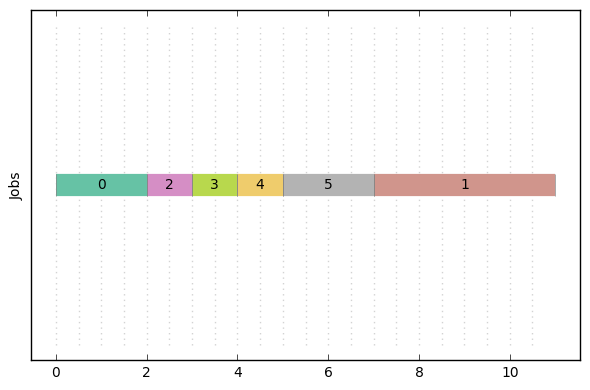

In [6]:
import docplex.cp.utils_visu as visu
if sol:
    visu.panel("Jobs")
    for i in range(n):
        visu.interval(sol.get_var_solution(jobs[i]), i, str(i))
    visu.show()